# MNIST Convolutional GAN Model

In [86]:
### Since this model incorporates data from the MNIST dataset and utilizes several epochs to improve traning of the discriminator and generator of the
### network, it is recommended that you run this program with a dedicated GPU if available as it will take roughly two hours on the CPU alone.
### Therefore, it is recommended to run this program on HiPerGator with a GPU and a minimum of 6 Gb of memory and it will take roughly 20 minutes total.
### Additionally, you can reduce the time of compiling by reducing the number of epochs, however, this will reduce the overall efficiacy of the model.

In [113]:
%matplotlib inline

import torch 
from torch import nn
import math
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils
from tqdm.notebook import tqdm

In [114]:
#Manual Seed to replicate the experiment
torch.manual_seed(69)

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Preparing the Training Data
For this example we will be using the MNIST dataset which contains grayscale 28x28 sized images of handwritten digits from zero to nine. Then using Pytorch, conversions will be made to tensors with a range of 0 to 1. The Transforms.ToTensor() funciton works to convert the data to a PyTorch tensor which is a multidimensional array similar to that of a NumPy array. The 
Normalize function works to change the range from -1 to 1 instead.

Since the original values of the transforms.ToTensor are usually 0 to 1, the normalization to -1 and 1 is necessary as since most of the image backgrounds are black and are equal to zero, this is hinder the training of the models. Therefore, normalizing the tensor values is necessary to reduce the instance of zero and to improve the numer of elements that are different in value.

In [115]:
# some hyperparameters

latent_dim = 100
image_size = 28
channels = 1

In [116]:
trsfrm = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,),(0.5,))]
)

In [117]:
#Using the native data call in torchvision of the MNIST dataset
#setting download to true has the MNIST dataset downloaded the first instance the code is run
#Then the data will be stored in the current working directory

train_d = datasets.MNIST(
    root="./data", train=True, download=True, transform=trsfrm
)

In [118]:
#The batch_s variable denotes the number of samples that will be used from the MNIST dataset to train the Discriminator
#and the total number of values for training in general
#Changing this value will require a change in the parameter setup for the discriminator and generator
#The tain_ld varaible calls the pytorch data loader which will shuffle data from the called dataset and return the set number of samples

batch_s = 128

train_ld = DataLoader(
    train_d, 
    batch_size = batch_s, 
    shuffle = True
)

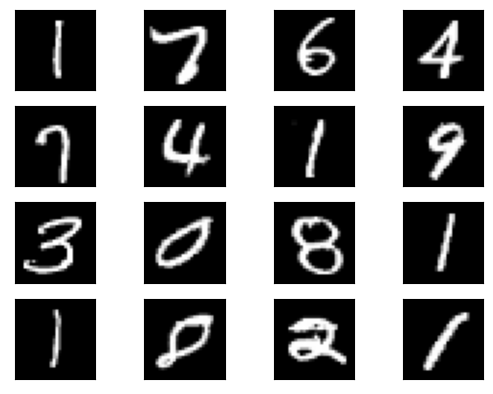

In [130]:
#An example of the numbers from the MNIST dataset
samples, mnist_labels = next(iter(train_ld))
for i in range(16):
    axis = plt.subplot(4, 4, i+1)
    plt.imshow(samples[i].reshape(28,28), cmap="gray")
    plt.xticks([])
    plt.yticks([])

# Implementing the Discriminator and Generator
The Discriminator for this example will be a multilayer preceptrons (MLP) neural network that will provide the probability that the image it receives belongs to the real training data

In [121]:
# Discriminator

class Discrim(nn.Module):
    def __init__(self): #This is used to build the model
        super().__init__() #This is used to run the model from the nn.Module of PyTorch
        self.model = nn.Sequential(
        nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self,x): #This will describe how the output is calculated. X is the two dimensional tensor that is the model
        output = self.model(x).view(-1, 1).squeeze(1)
        return output


In [122]:
discrim = Discrim().to(device=device)

## Generator Creation

In [123]:
# Generator
    
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64 * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self,x):
        output = self.model(x)
        return output

In [124]:
gen = Gen().to(device=device)

# Training the Model

In [131]:
#Setting the training parameters:
#The learning rate is what is used to adapt the network weights
#The number of epochs indicates the number of repetitions of training using the entire training set
#The loss function uses the binary cross-entropy function and considers a binary classification task suitable for training the generator

learningr = 0.0001
epochs_num = 100
loss_func = nn.BCELoss() 

#Since Pytorch uses different weight update rules for model training in torch.optim, using the Adam algorithm will be done to train the discriminator and generator.

optimize_discrim = optim.Adam(discrim.parameters(), lr=learningr, betas=(0.5, 0.999))
optimize_gen = optim.Adam(gen.parameters(), lr = learningr, betas=(0.5, 0.999))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 Loss D.: 1.1581192016601562
Epoch: 1 Loss G.: 1.0958564281463623


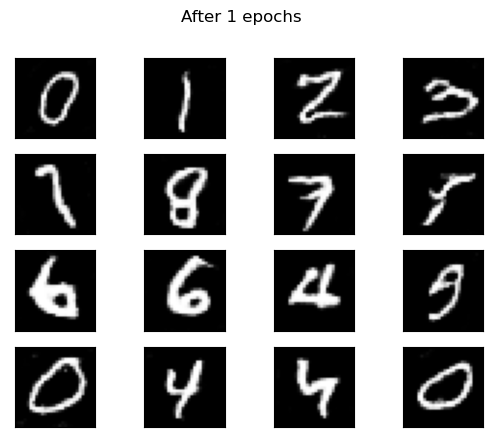

Epoch: 2 Loss D.: 0.5528393983840942
Epoch: 2 Loss G.: 3.8297252655029297


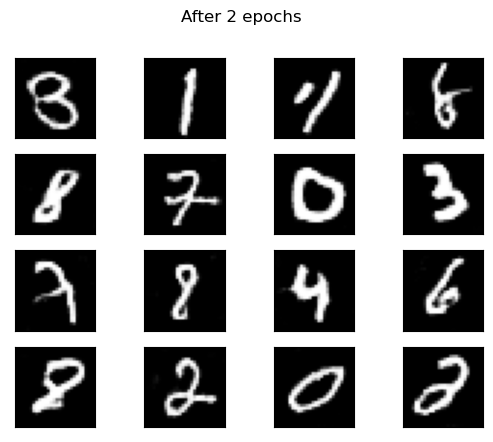

Epoch: 3 Loss D.: 0.602453351020813
Epoch: 3 Loss G.: 3.342050552368164


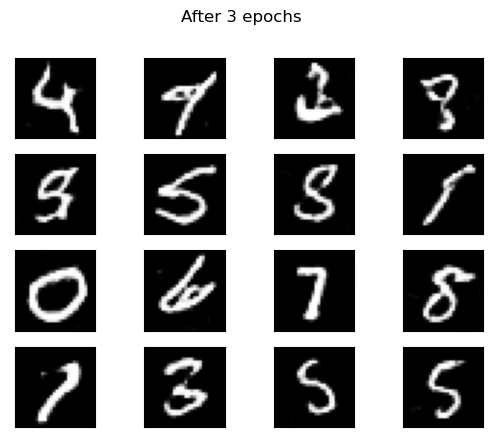

Epoch: 4 Loss D.: 0.3249286115169525
Epoch: 4 Loss G.: 2.8535871505737305


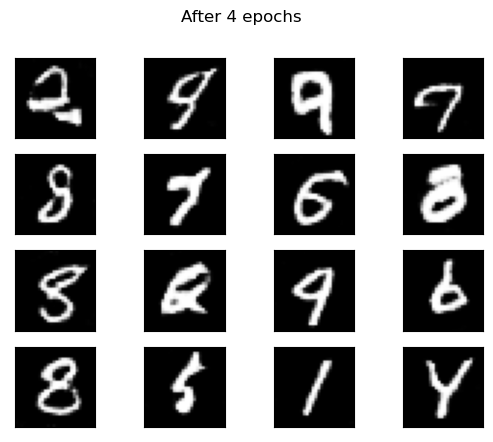

Epoch: 5 Loss D.: 0.34264612197875977
Epoch: 5 Loss G.: 2.465261459350586


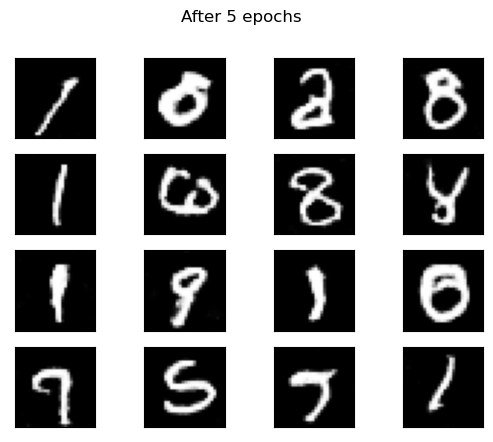

Epoch: 6 Loss D.: 0.4745059311389923
Epoch: 6 Loss G.: 1.6575465202331543


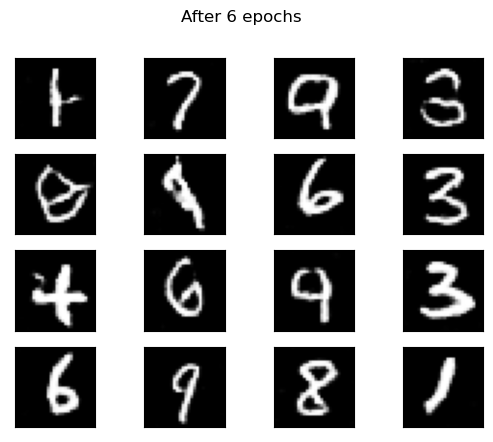

Epoch: 7 Loss D.: 0.2660433053970337
Epoch: 7 Loss G.: 2.7407145500183105


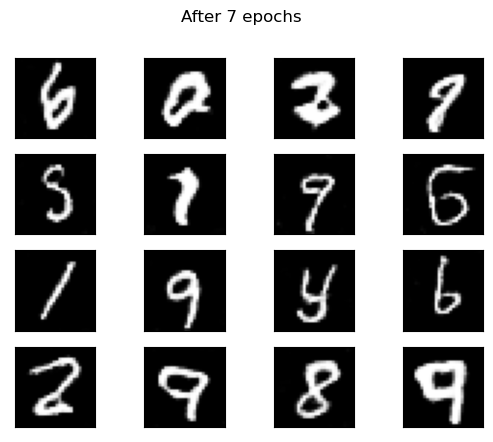

Epoch: 8 Loss D.: 0.5791723728179932
Epoch: 8 Loss G.: 2.4108755588531494


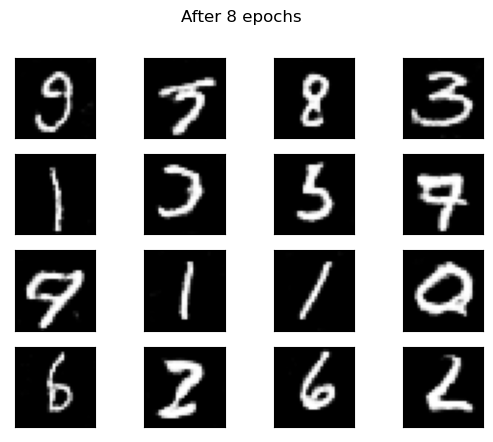

Epoch: 9 Loss D.: 0.263107031583786
Epoch: 9 Loss G.: 2.578617572784424


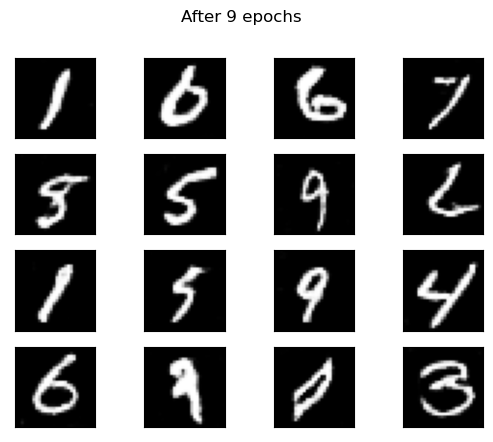

Epoch: 10 Loss D.: 0.3754671812057495
Epoch: 10 Loss G.: 2.6561012268066406


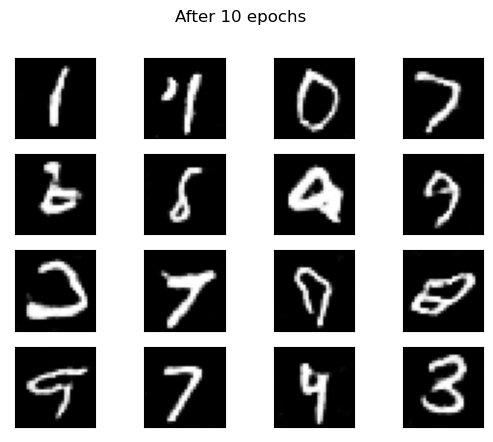

Epoch: 11 Loss D.: 0.3229920268058777
Epoch: 11 Loss G.: 3.4779582023620605


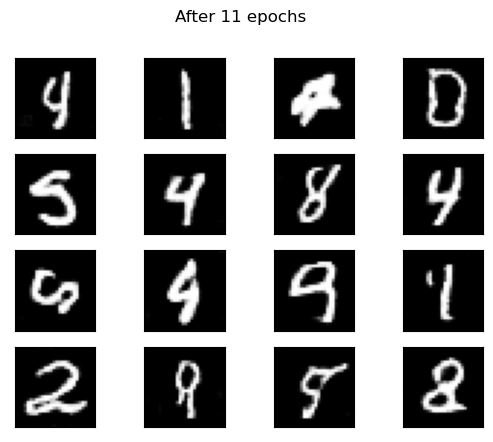

Epoch: 12 Loss D.: 0.21764978766441345
Epoch: 12 Loss G.: 2.8282790184020996


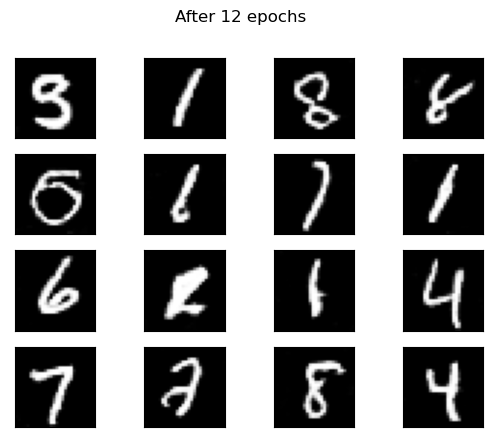

Epoch: 13 Loss D.: 0.39088568091392517
Epoch: 13 Loss G.: 3.206390380859375


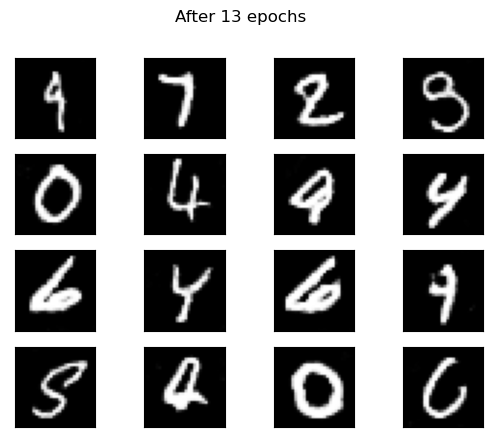

Epoch: 14 Loss D.: 0.30387192964553833
Epoch: 14 Loss G.: 3.685246467590332


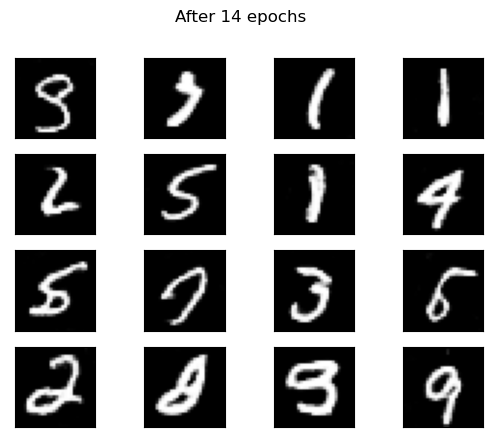

Epoch: 15 Loss D.: 0.39297249913215637
Epoch: 15 Loss G.: 2.211087465286255


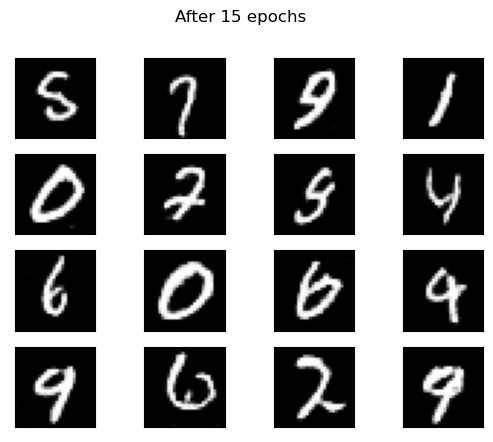

Epoch: 16 Loss D.: 0.3183402419090271
Epoch: 16 Loss G.: 4.396541595458984


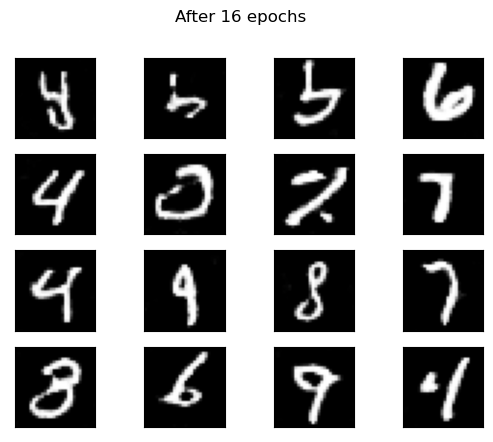

Epoch: 17 Loss D.: 0.35211026668548584
Epoch: 17 Loss G.: 2.0011110305786133


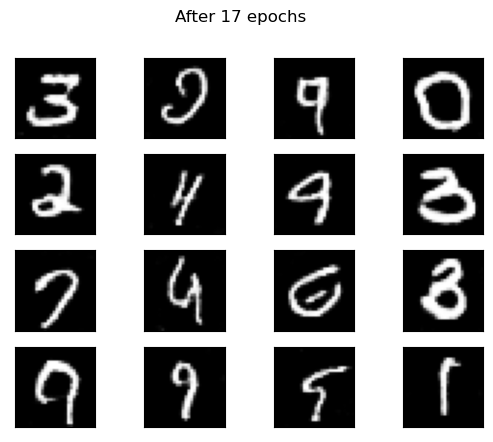

Epoch: 18 Loss D.: 0.2410004734992981
Epoch: 18 Loss G.: 2.4782180786132812


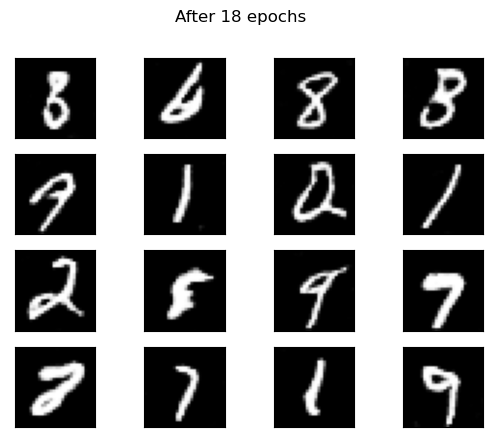

Epoch: 19 Loss D.: 0.2960788905620575
Epoch: 19 Loss G.: 2.619174003601074


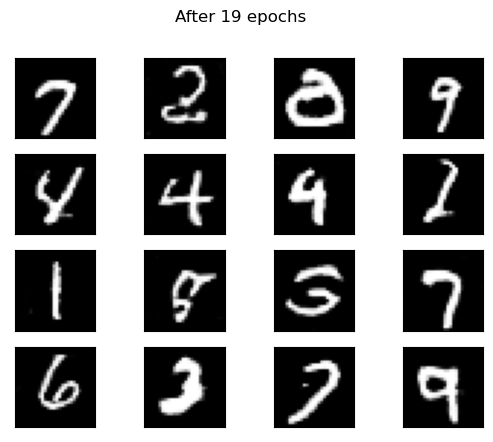

Epoch: 20 Loss D.: 0.30107542872428894
Epoch: 20 Loss G.: 2.3703253269195557


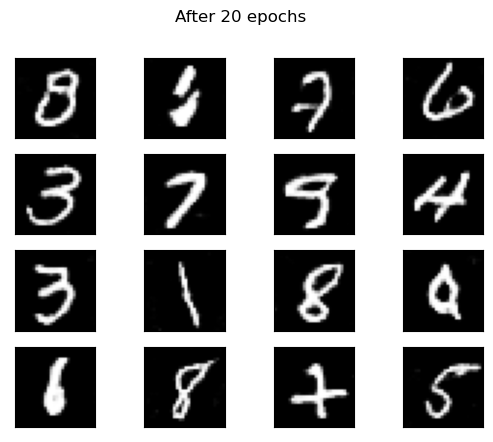

Epoch: 21 Loss D.: 0.16398373246192932
Epoch: 21 Loss G.: 2.6971983909606934


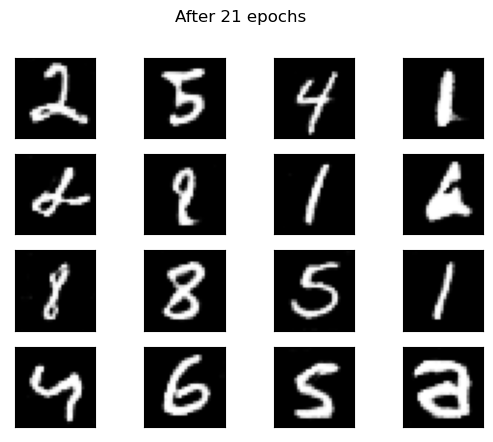

Epoch: 22 Loss D.: 0.2933846414089203
Epoch: 22 Loss G.: 3.309659957885742


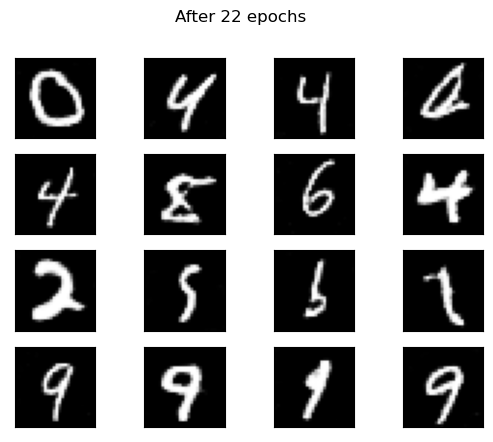

Epoch: 23 Loss D.: 0.33283892273902893
Epoch: 23 Loss G.: 3.2487568855285645


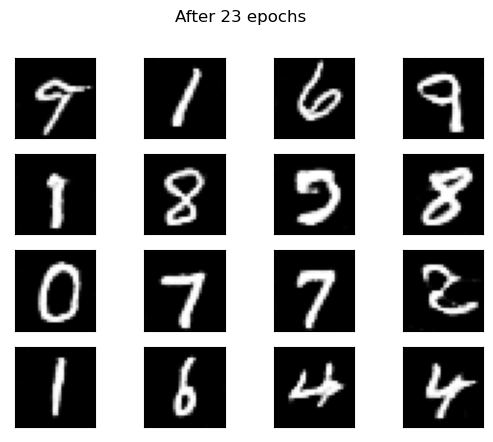

Epoch: 24 Loss D.: 0.20676729083061218
Epoch: 24 Loss G.: 3.043978214263916


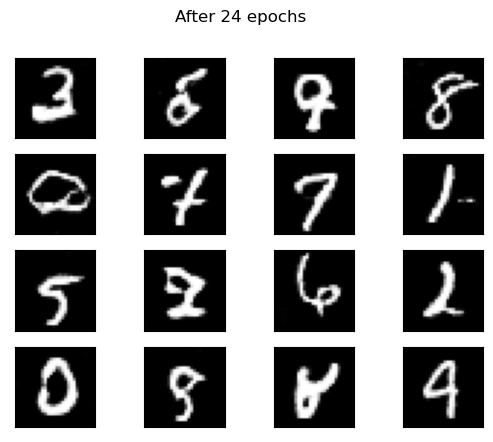

Epoch: 25 Loss D.: 0.21965479850769043
Epoch: 25 Loss G.: 2.4848744869232178


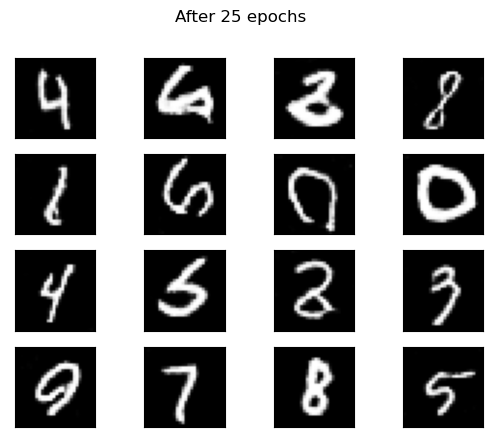

Epoch: 26 Loss D.: 0.23711100220680237
Epoch: 26 Loss G.: 2.892714500427246


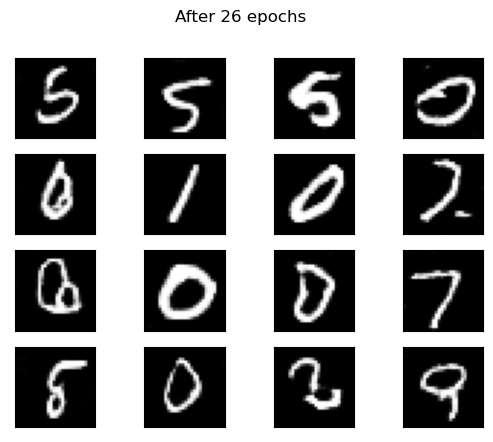

Epoch: 27 Loss D.: 0.2972957491874695
Epoch: 27 Loss G.: 2.6009271144866943


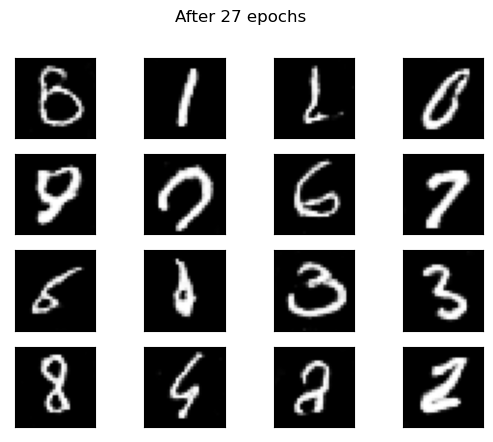

Epoch: 28 Loss D.: 0.23464927077293396
Epoch: 28 Loss G.: 2.561509132385254


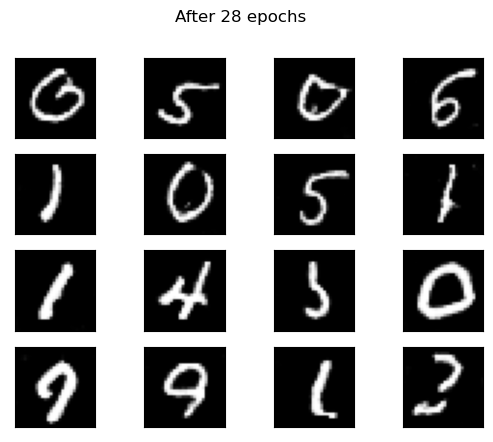

Epoch: 29 Loss D.: 0.29027286171913147
Epoch: 29 Loss G.: 2.0371804237365723


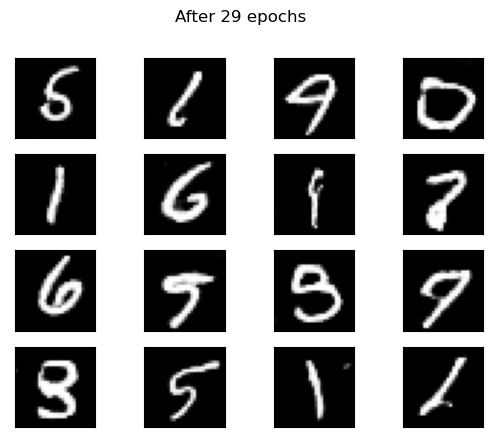

Epoch: 30 Loss D.: 0.37590110301971436
Epoch: 30 Loss G.: 2.0981996059417725


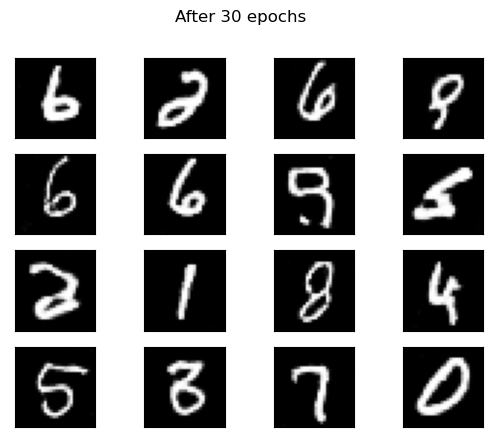

Epoch: 31 Loss D.: 0.6799792051315308
Epoch: 31 Loss G.: 0.5252063274383545


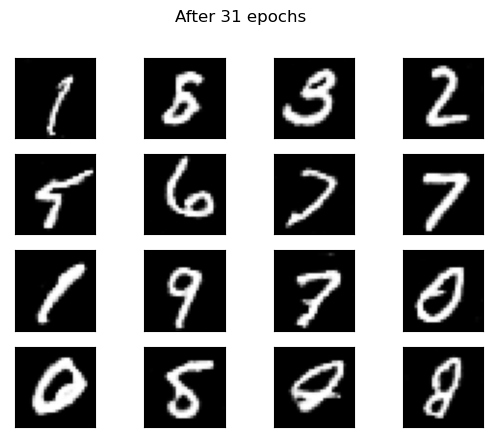

Epoch: 32 Loss D.: 0.2529968023300171
Epoch: 32 Loss G.: 3.891632556915283


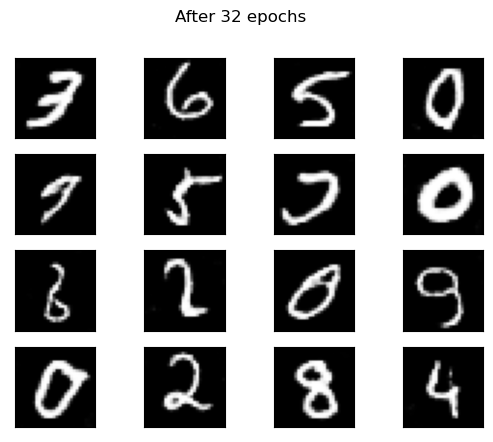

Epoch: 33 Loss D.: 0.2715951204299927
Epoch: 33 Loss G.: 2.6725497245788574


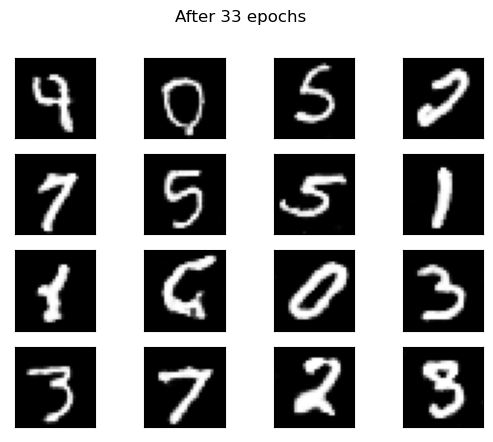

Epoch: 34 Loss D.: 0.27194178104400635
Epoch: 34 Loss G.: 2.0193705558776855


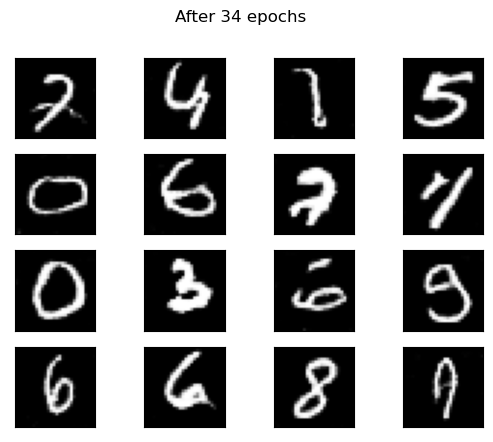

Epoch: 35 Loss D.: 0.5701164603233337
Epoch: 35 Loss G.: 4.968906402587891


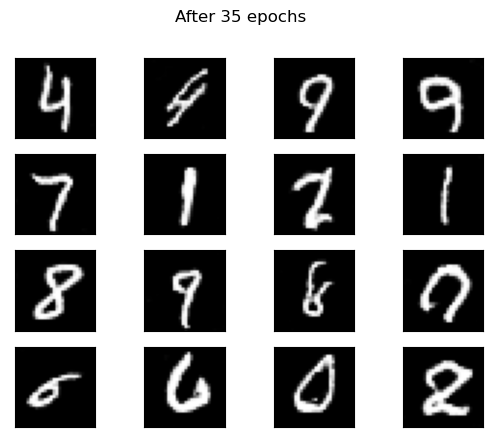

Epoch: 36 Loss D.: 0.33533531427383423
Epoch: 36 Loss G.: 2.9885058403015137


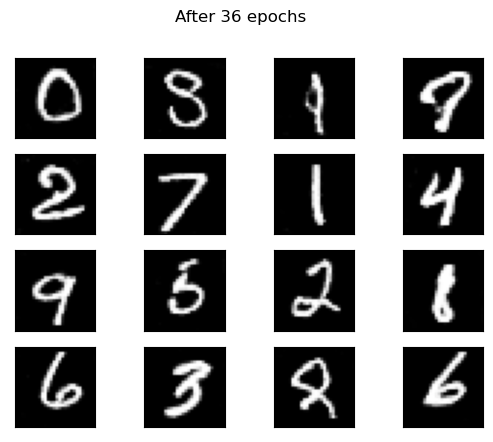

Epoch: 37 Loss D.: 0.260480672121048
Epoch: 37 Loss G.: 3.8552069664001465


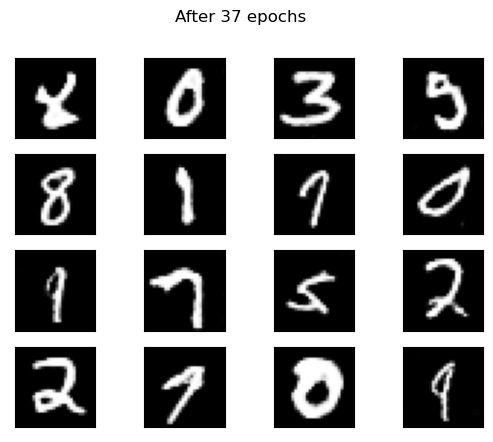

Epoch: 38 Loss D.: 0.17433631420135498
Epoch: 38 Loss G.: 3.079519748687744


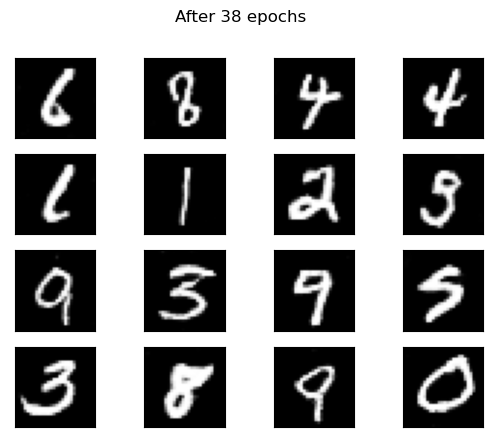

Epoch: 39 Loss D.: 0.17549282312393188
Epoch: 39 Loss G.: 3.4318230152130127


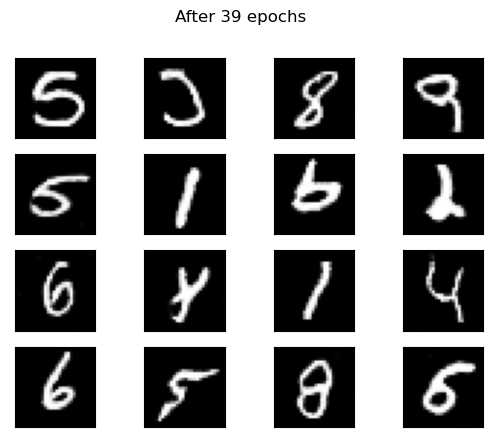

Epoch: 40 Loss D.: 0.2314748764038086
Epoch: 40 Loss G.: 3.924661636352539


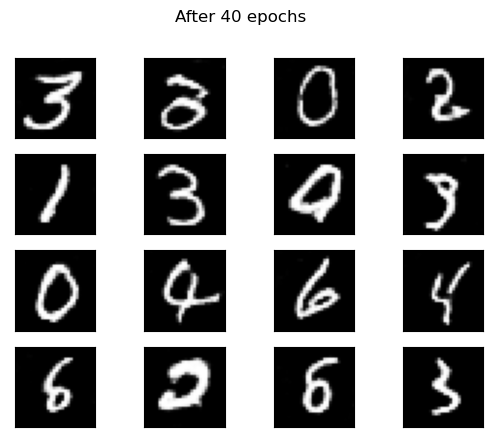

Epoch: 41 Loss D.: 0.6711874008178711
Epoch: 41 Loss G.: 0.9305148124694824


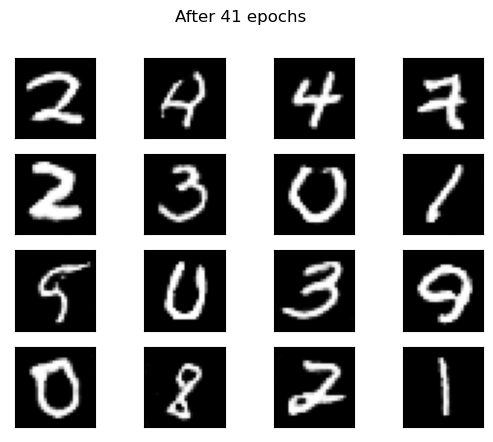

Epoch: 42 Loss D.: 0.24470388889312744
Epoch: 42 Loss G.: 2.2216975688934326


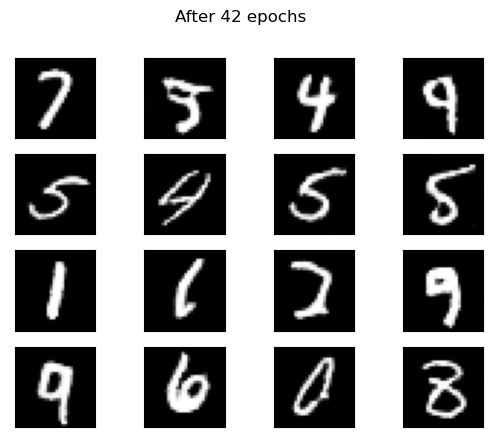

Epoch: 43 Loss D.: 0.4784296751022339
Epoch: 43 Loss G.: 5.920938968658447


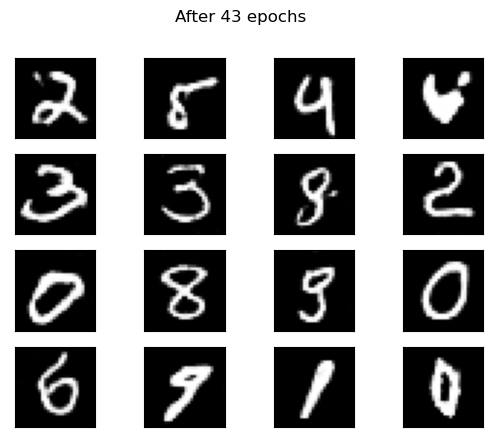

Epoch: 44 Loss D.: 0.1201796755194664
Epoch: 44 Loss G.: 3.7346341609954834


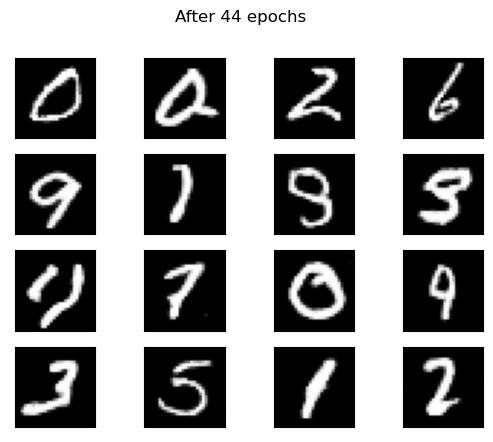

Epoch: 45 Loss D.: 0.0898539125919342
Epoch: 45 Loss G.: 3.962275981903076


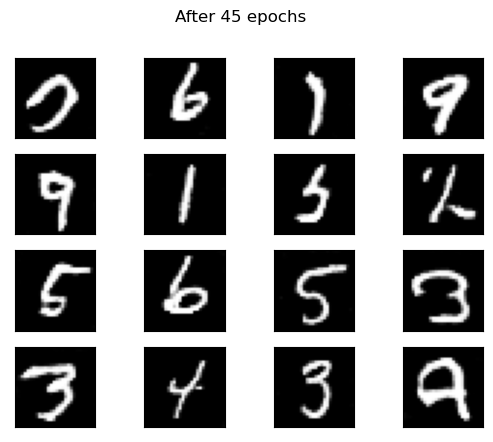

Epoch: 46 Loss D.: 0.4642942547798157
Epoch: 46 Loss G.: 2.6211748123168945


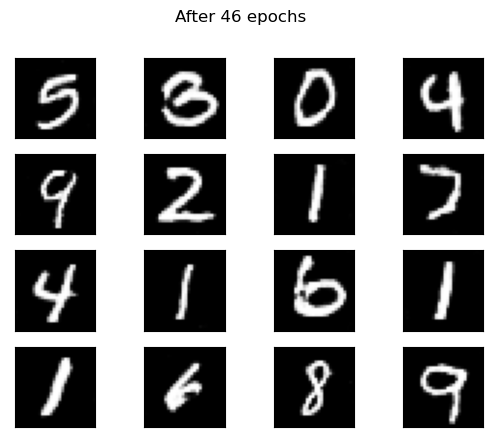

Epoch: 47 Loss D.: 0.18236735463142395
Epoch: 47 Loss G.: 4.058592796325684


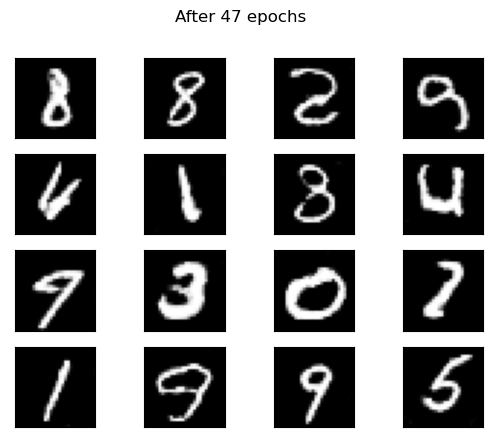

Epoch: 48 Loss D.: 0.6630246639251709
Epoch: 48 Loss G.: 6.1211042404174805


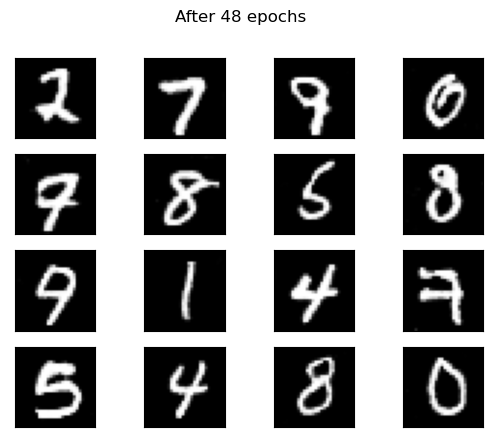

Epoch: 49 Loss D.: 0.1802060306072235
Epoch: 49 Loss G.: 3.0565614700317383


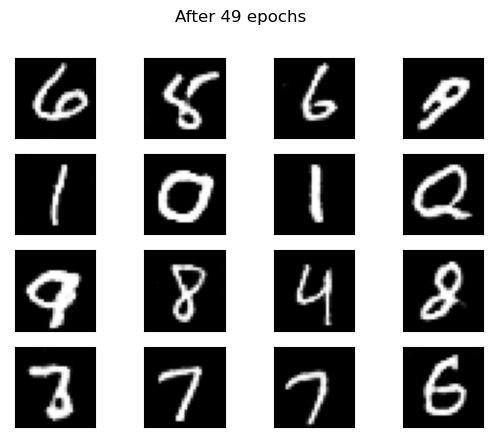

Epoch: 50 Loss D.: 0.19182705879211426
Epoch: 50 Loss G.: 4.114865303039551


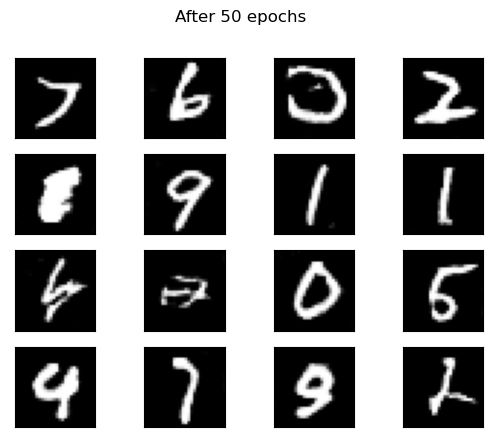

Epoch: 51 Loss D.: 0.16818255186080933
Epoch: 51 Loss G.: 3.007056474685669


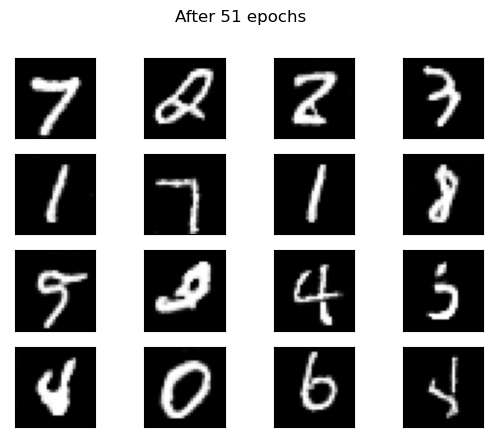

Epoch: 52 Loss D.: 0.27677202224731445
Epoch: 52 Loss G.: 4.242344856262207


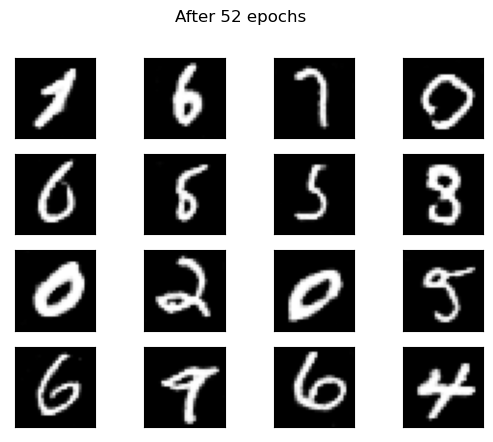

Epoch: 53 Loss D.: 0.45009708404541016
Epoch: 53 Loss G.: 2.3553552627563477


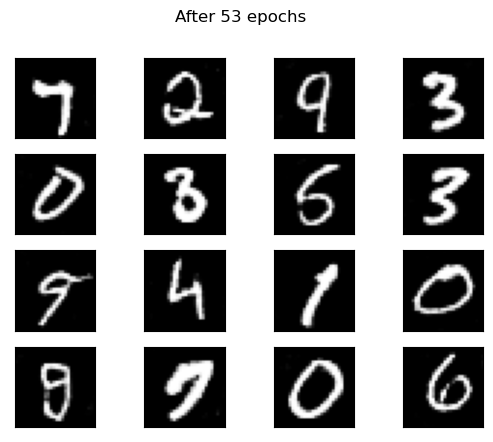

Epoch: 54 Loss D.: 0.1780097633600235
Epoch: 54 Loss G.: 4.012818336486816


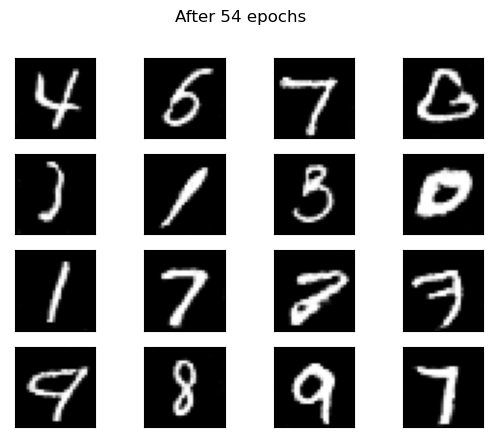

Epoch: 55 Loss D.: 0.14492760598659515
Epoch: 55 Loss G.: 3.136110305786133


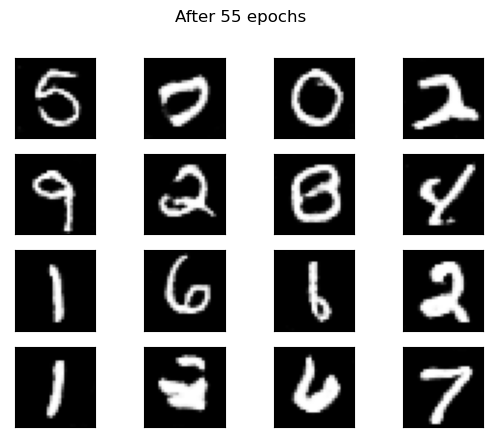

Epoch: 56 Loss D.: 0.25370267033576965
Epoch: 56 Loss G.: 2.3404955863952637


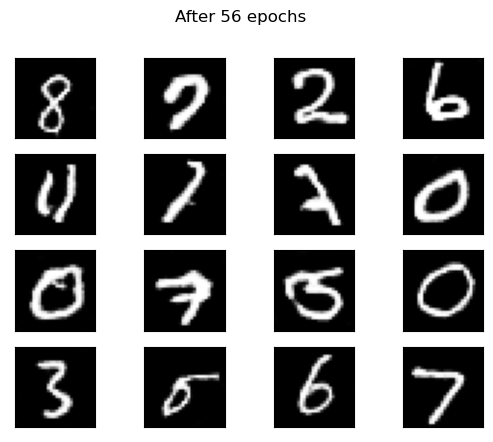

Epoch: 57 Loss D.: 0.3492349088191986
Epoch: 57 Loss G.: 3.338548183441162


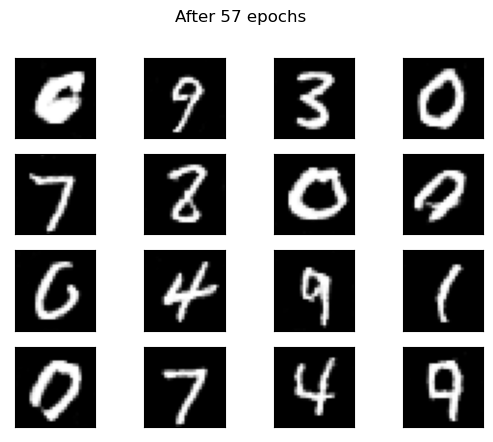

Epoch: 58 Loss D.: 0.7515506148338318
Epoch: 58 Loss G.: 3.2207696437835693


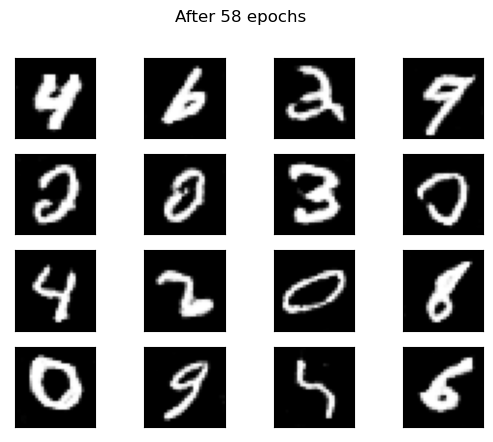

Epoch: 59 Loss D.: 0.1490599513053894
Epoch: 59 Loss G.: 3.4095091819763184


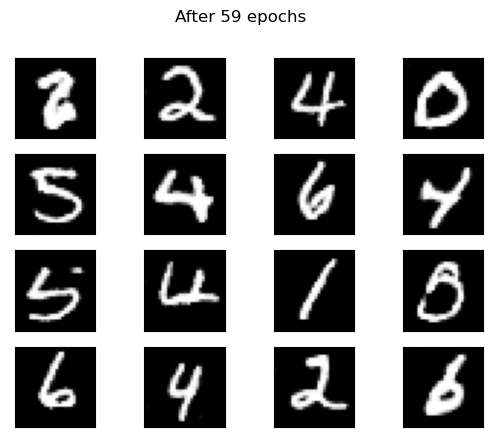

Epoch: 60 Loss D.: 0.24677416682243347
Epoch: 60 Loss G.: 2.844326972961426


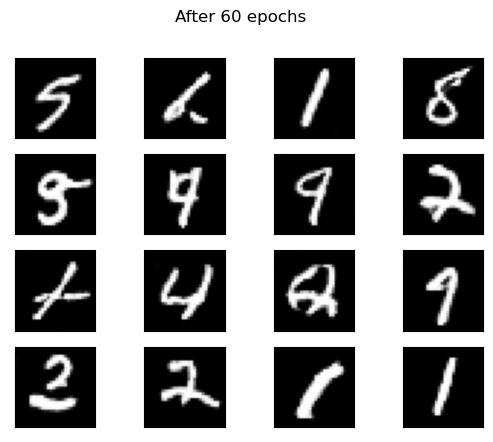

Epoch: 61 Loss D.: 0.21862171590328217
Epoch: 61 Loss G.: 2.6979727745056152


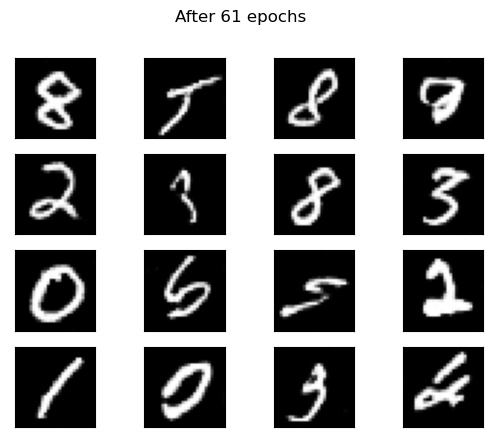

Epoch: 62 Loss D.: 0.13395102322101593
Epoch: 62 Loss G.: 3.9903900623321533


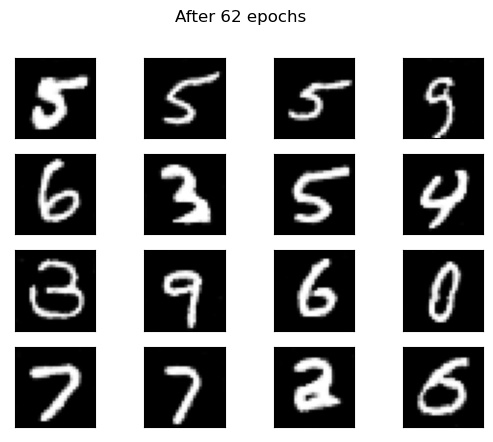

Epoch: 63 Loss D.: 0.2853342592716217
Epoch: 63 Loss G.: 2.2553887367248535


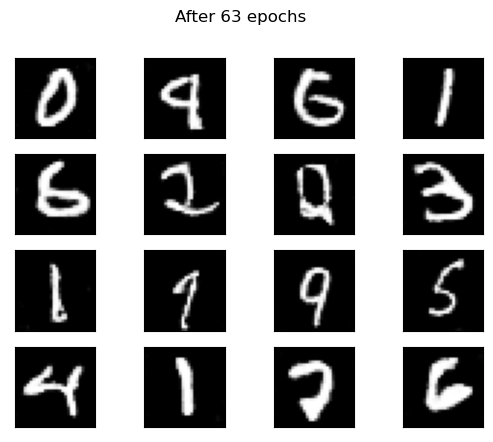

Epoch: 64 Loss D.: 0.29973122477531433
Epoch: 64 Loss G.: 3.4897828102111816


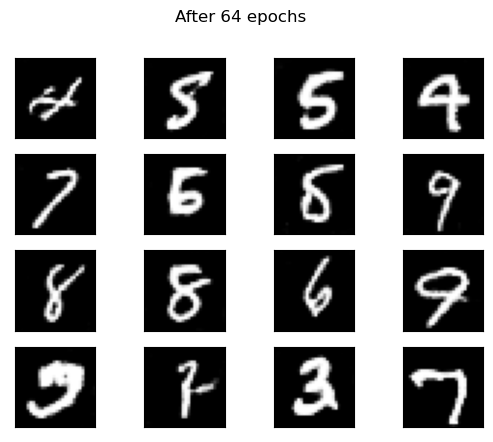

Epoch: 65 Loss D.: 0.8602591156959534
Epoch: 65 Loss G.: 6.348018646240234


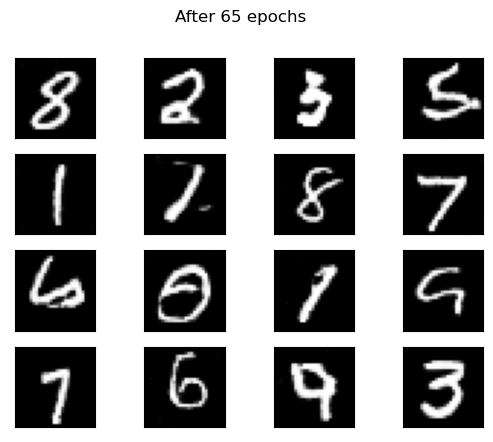

Epoch: 66 Loss D.: 0.18581238389015198
Epoch: 66 Loss G.: 3.838547706604004


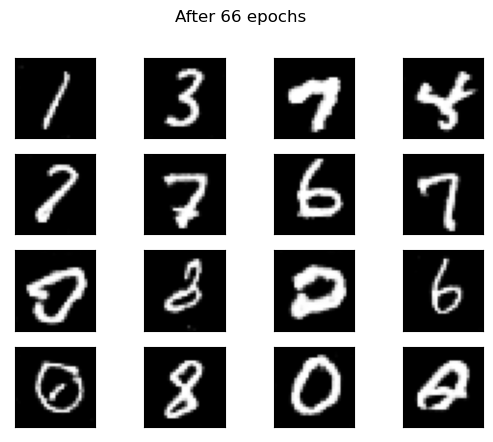

Epoch: 67 Loss D.: 2.9422523975372314
Epoch: 67 Loss G.: 0.005724836140871048


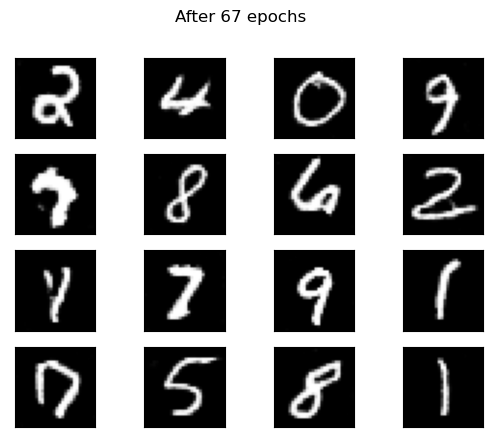

Epoch: 68 Loss D.: 0.093412846326828
Epoch: 68 Loss G.: 3.961557388305664


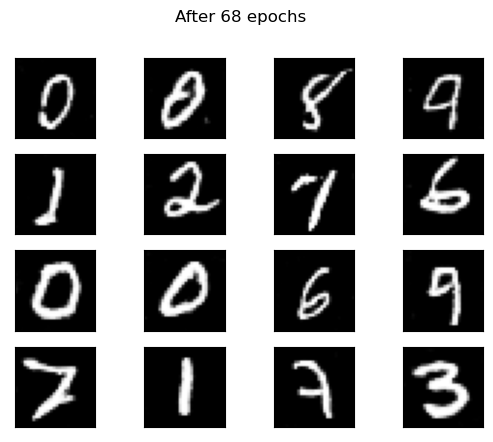

Epoch: 69 Loss D.: 0.23792681097984314
Epoch: 69 Loss G.: 5.720986843109131


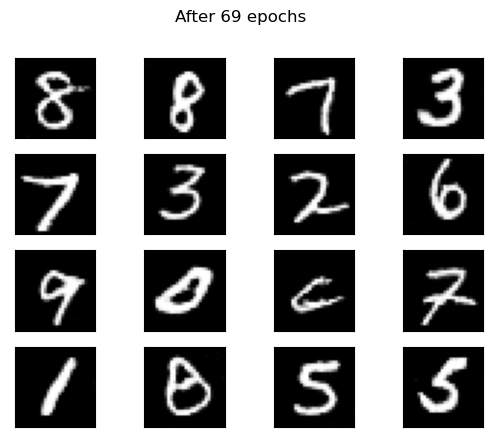

Epoch: 70 Loss D.: 0.33245763182640076
Epoch: 70 Loss G.: 1.4965040683746338


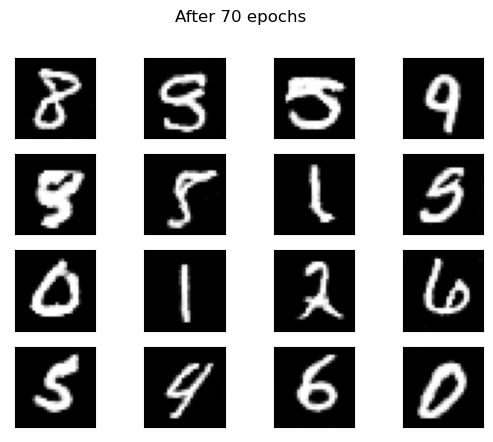

Epoch: 71 Loss D.: 0.14759904146194458
Epoch: 71 Loss G.: 3.2648448944091797


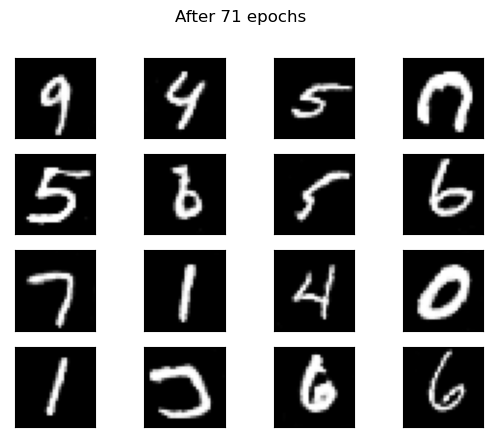

Epoch: 72 Loss D.: 0.19758892059326172
Epoch: 72 Loss G.: 3.8660309314727783


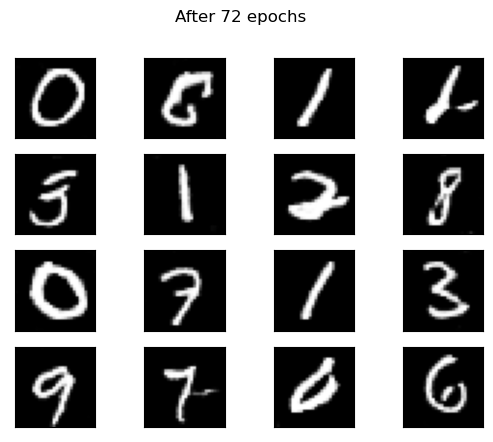

Epoch: 73 Loss D.: 0.4457380175590515
Epoch: 73 Loss G.: 2.9894795417785645


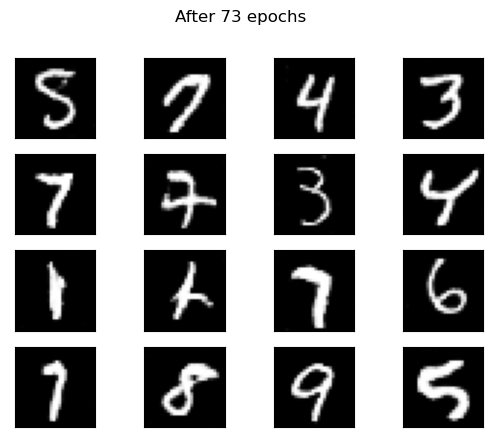

Epoch: 74 Loss D.: 0.15958702564239502
Epoch: 74 Loss G.: 3.507631301879883


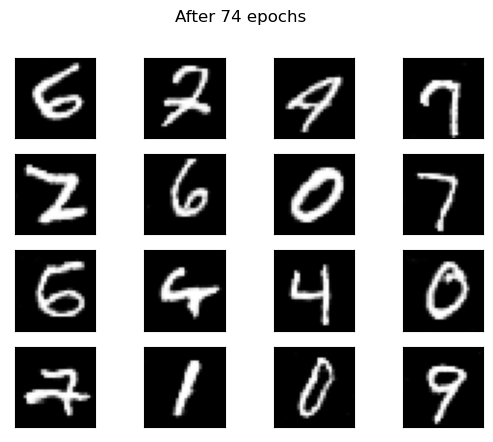

Epoch: 75 Loss D.: 0.26662468910217285
Epoch: 75 Loss G.: 2.5250234603881836


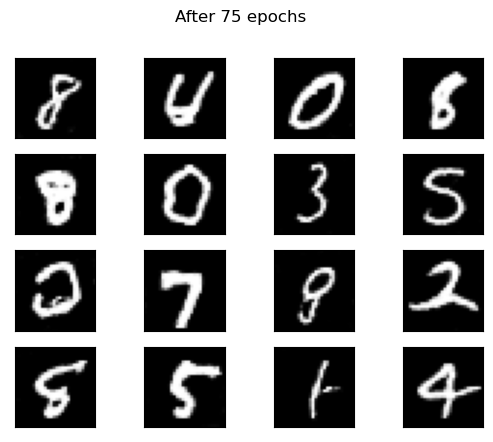

Epoch: 76 Loss D.: 2.713233709335327
Epoch: 76 Loss G.: 10.701980590820312


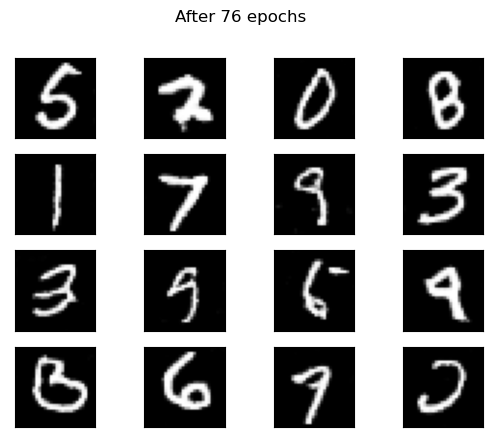

Epoch: 77 Loss D.: 0.153423011302948
Epoch: 77 Loss G.: 4.642063617706299


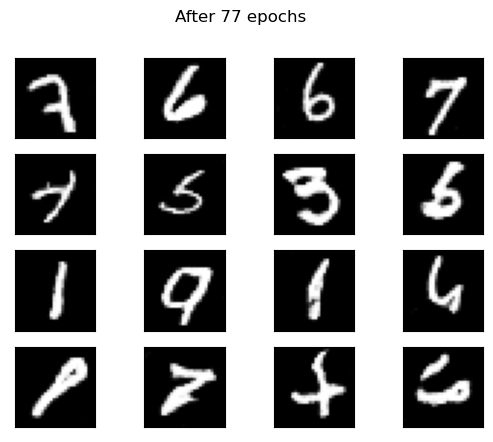

Epoch: 78 Loss D.: 0.09044192731380463
Epoch: 78 Loss G.: 4.278456687927246


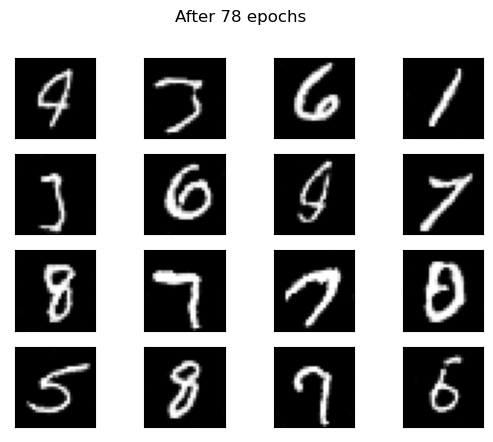

Epoch: 79 Loss D.: 0.1770927459001541
Epoch: 79 Loss G.: 4.501241683959961


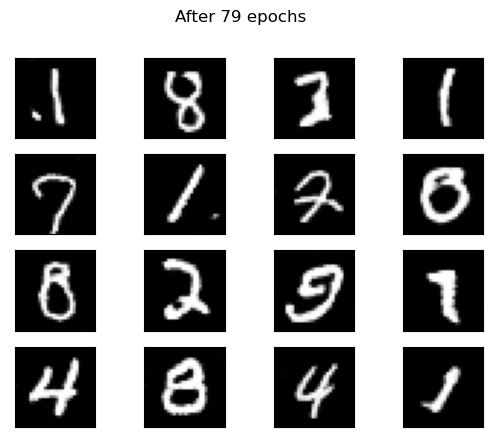

Epoch: 80 Loss D.: 0.12880754470825195
Epoch: 80 Loss G.: 3.103639841079712


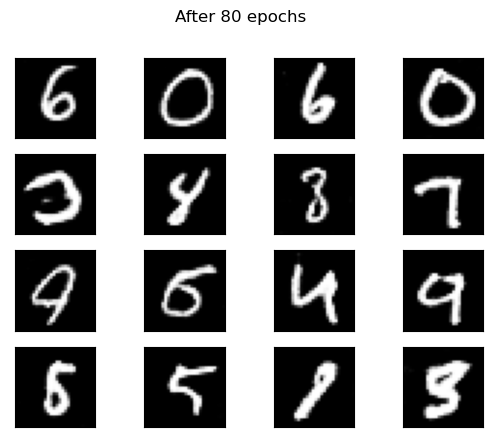

Epoch: 81 Loss D.: 0.13514544069766998
Epoch: 81 Loss G.: 3.7560582160949707


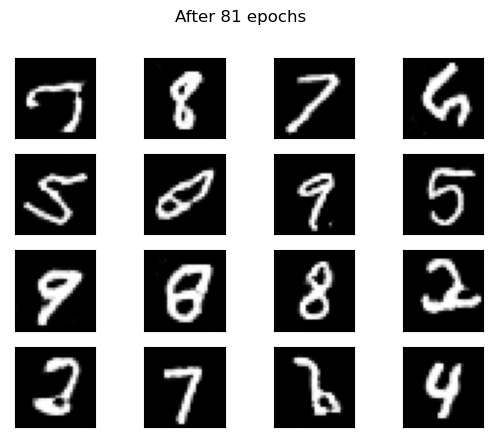

Epoch: 82 Loss D.: 0.3115047812461853
Epoch: 82 Loss G.: 2.1521403789520264


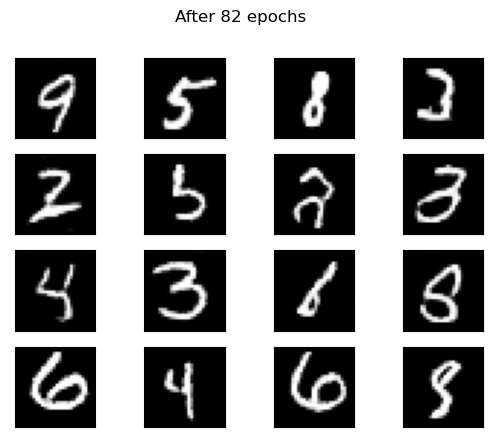

Epoch: 83 Loss D.: 0.14565512537956238
Epoch: 83 Loss G.: 3.905423641204834


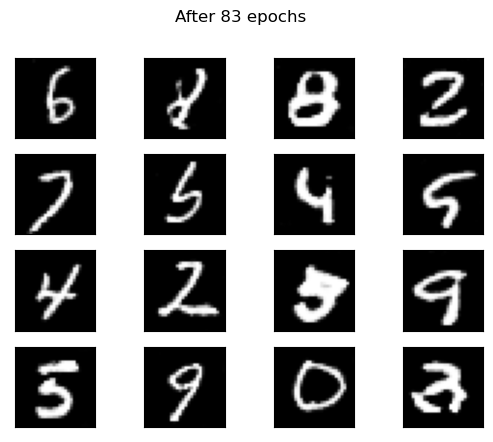

Epoch: 84 Loss D.: 0.14446912705898285
Epoch: 84 Loss G.: 3.782447576522827


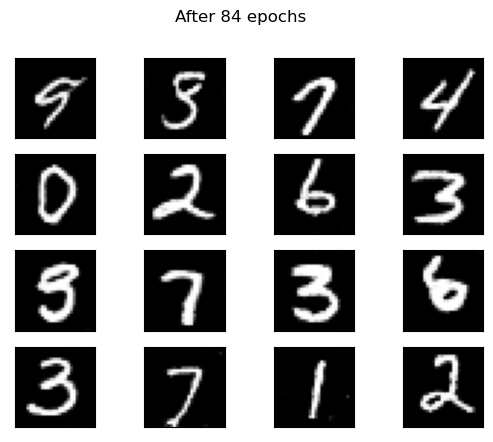

Epoch: 85 Loss D.: 0.23038241267204285
Epoch: 85 Loss G.: 5.301472187042236


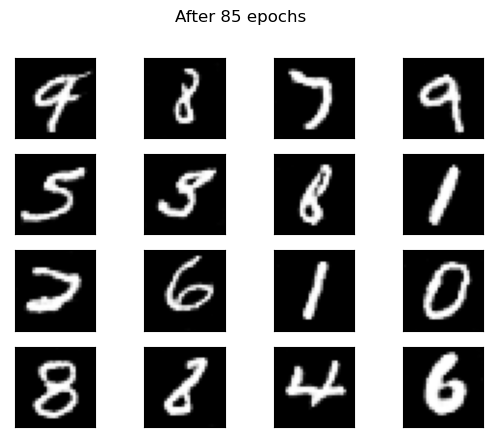

Epoch: 86 Loss D.: 0.1931978017091751
Epoch: 86 Loss G.: 3.266918182373047


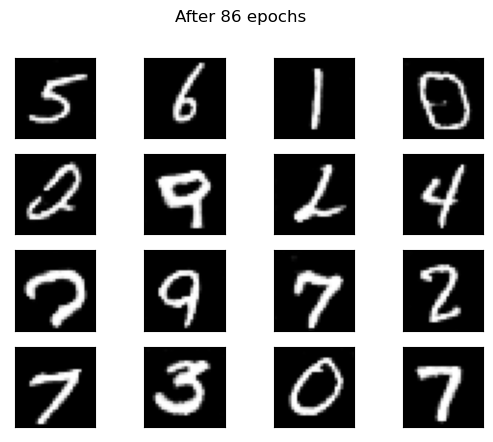

Epoch: 87 Loss D.: 0.11076917499303818
Epoch: 87 Loss G.: 5.004622936248779


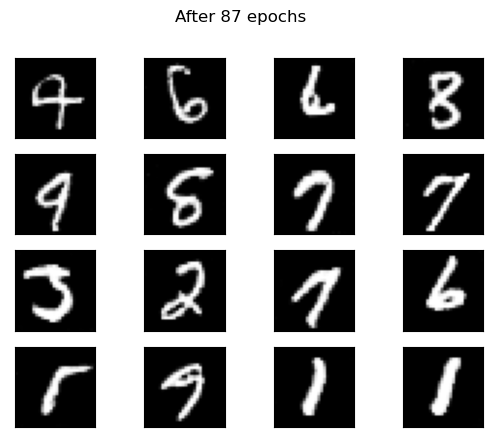

Epoch: 88 Loss D.: 0.37314748764038086
Epoch: 88 Loss G.: 2.784282684326172


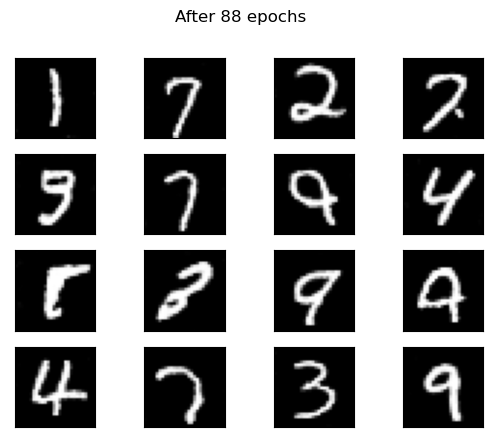

Epoch: 89 Loss D.: 0.10124729573726654
Epoch: 89 Loss G.: 3.8616881370544434


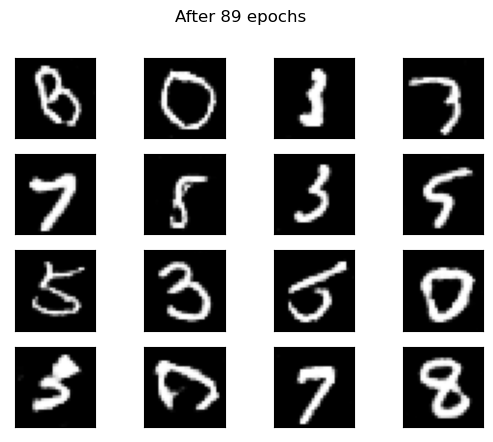

Epoch: 90 Loss D.: 0.11012714356184006
Epoch: 90 Loss G.: 3.648808002471924


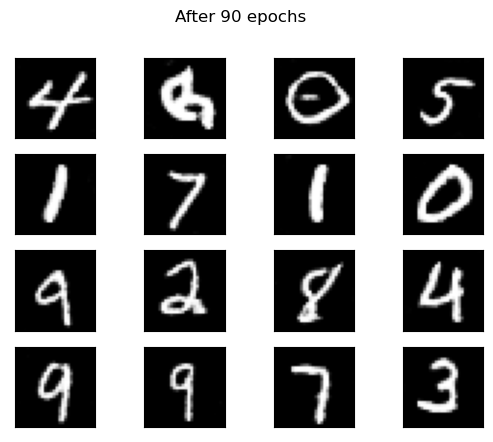

Epoch: 91 Loss D.: 0.08084368705749512
Epoch: 91 Loss G.: 4.511265277862549


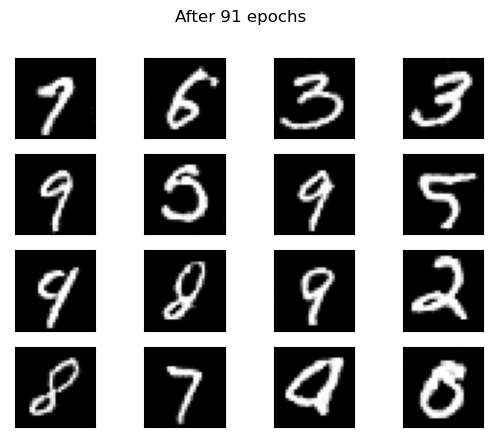

Epoch: 92 Loss D.: 0.20273198187351227
Epoch: 92 Loss G.: 4.832273006439209


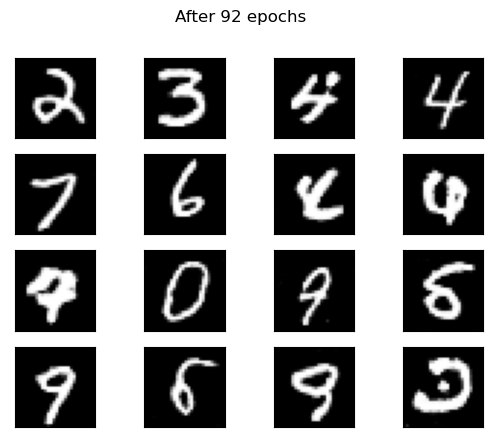

Epoch: 93 Loss D.: 0.20717397332191467
Epoch: 93 Loss G.: 5.058312892913818


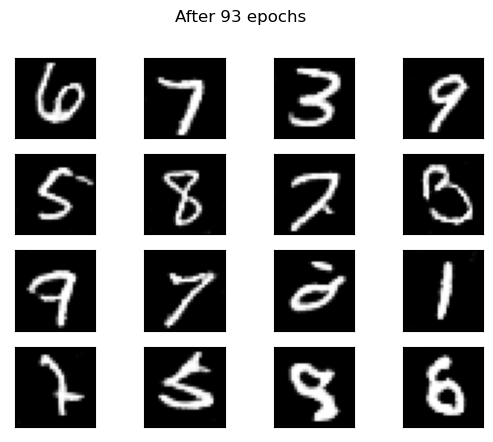

Epoch: 94 Loss D.: 0.32675355672836304
Epoch: 94 Loss G.: 6.034367561340332


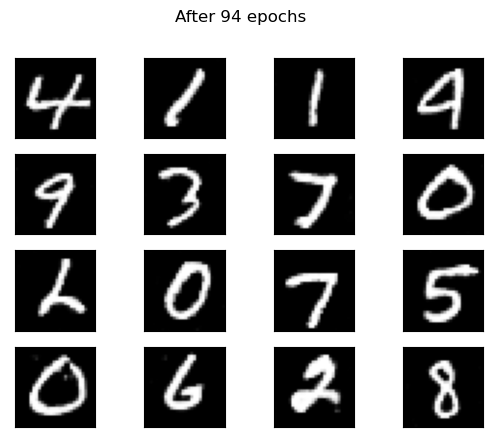

Epoch: 95 Loss D.: 0.16293154656887054
Epoch: 95 Loss G.: 4.092677116394043


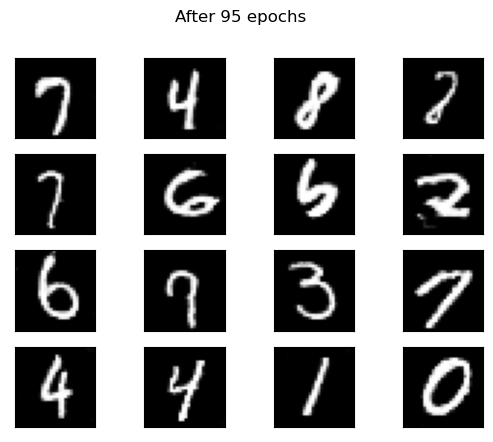

Epoch: 96 Loss D.: 0.1385740041732788
Epoch: 96 Loss G.: 4.369184494018555


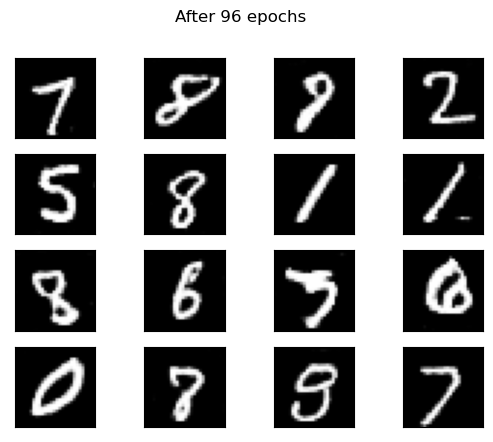

Epoch: 97 Loss D.: 0.2740458846092224
Epoch: 97 Loss G.: 2.665437698364258


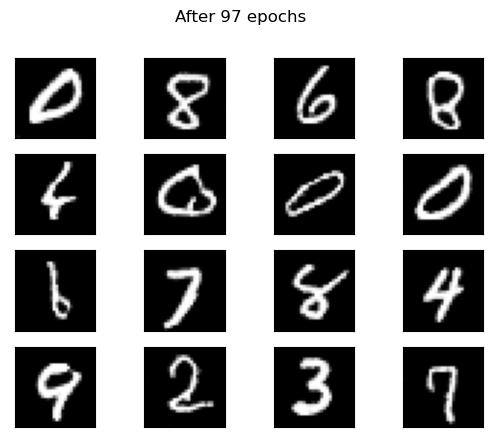

Epoch: 98 Loss D.: 0.6117456555366516
Epoch: 98 Loss G.: 4.545069694519043


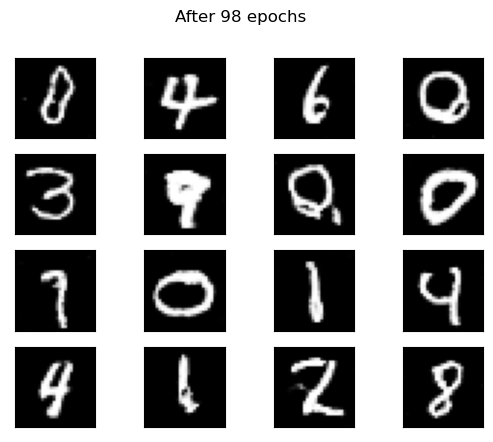

Epoch: 99 Loss D.: 0.09104232490062714
Epoch: 99 Loss G.: 4.604684829711914


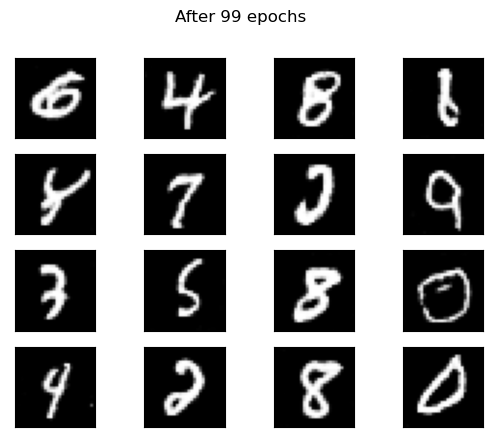

Epoch: 100 Loss D.: 0.11720854043960571
Epoch: 100 Loss G.: 4.354425430297852


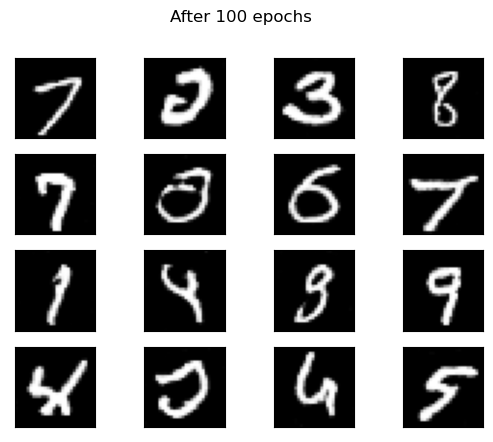

In [132]:
#training loop

for epoch in tqdm(range(epochs_num)):
    for i, (images, _) in enumerate(train_ld):
        current_batch_size = images.size(0)
        images = images.to(device)
        real_labels = torch.ones(current_batch_size, device=device)
        fake_labels = torch.zeros(current_batch_size, device=device)

        # Train discriminator
        optimize_discrim.zero_grad()
        real_outputs = discrim(images)
        real_loss = loss_func(real_outputs, real_labels)
        real_score = real_outputs

        noise = torch.randn(current_batch_size, latent_dim, 1, 1, device=device)
        fake_images = gen(noise)
        fake_outputs = discrim(fake_images.detach())
        fake_loss = loss_func(fake_outputs, fake_labels)
        fake_score = fake_outputs

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimize_discrim.step()

        # Train generator
        optimize_gen.zero_grad()
        fake_outputs = discrim(fake_images)
        g_loss = loss_func(fake_outputs, real_labels)
        g_loss.backward()
        optimize_gen.step()
        
        if i==batch_s -1:
            print(f"Epoch: {epoch+1} Loss D.: {d_loss}")
            print(f"Epoch: {epoch+1} Loss G.: {g_loss}")
            
    #Creating images for each epoch of training to show how well the images created by the generator appear.
    fake_images = fake_images.cpu().detach() #Detatching the the generated samples is necessary to return a tensor from the computational graph to allow for computation of the gradients.
    fls = []
    imgs = []
    fig = plt.figure()
    filename = 'gen_fig_e%03d.png' % (epoch+1)
    for i in range(16):
        axis = fig.add_subplot(4,4,i+1)
        plt.imshow(fake_images[i].reshape(28,28),cmap="gray")
        plt.xticks([])
        plt.yticks([])
    fig.suptitle(f"After {epoch+1} epochs")
    fig.savefig(filename,transparent = False, facecolor = 'white')
    plt.show()
    
    if (epoch + 1) % 5 == 0:
        fake_images = fake_images.view(fake_images.size(0), channels, image_size, image_size)
        vutils.save_image(fake_images.data, f"./Samples/MNIST_CONV_GAN_samples_epoch_{epoch+1}.png", 
                          normalize=True)
    

In [ ]:
#save trained models

torch.save(gen.state_dict(), "MNIST_CONV_GAN_generator.pth")
torch.save(discrim.state_dict(), "MNIST_CONV_GAN_discriminator.pth")